In [4]:
import numpy as np
import pandas as pd

data_path = "ml-1m/ratings.dat"
df = pd.read_csv(data_path, header=None, sep="::", engine="python")
df.columns = ["user_id", "movie_id", "rating", "timestamp"]
df

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
n_users = df["user_id"].nunique()
n_movies = df["movie_id"].nunique()

print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Number of users: 6040
Number of movies: 3706


In [7]:
def load_user_rating_data(df, n_users, n_movies):
    data = np.zeros([n_users, n_movies], dtype=np.intc)
    movie_id_mapping = {}
    for user_id, movie_id, rating in zip(df["user_id"], df["movie_id"], df["rating"]):
        user_id = int(user_id) - 1
        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id] = len(movie_id_mapping)
        data[user_id, movie_id_mapping[movie_id]] = rating
    return data, movie_id_mapping


data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)

In [8]:
values, counts = np.unique(data, return_counts=True)
for value, count in zip(values, counts):
    print(f"Number of rating {value}: {count}")

Number of rating 0: 21384031
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226310


In [9]:
print(df["movie_id"].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: count, Length: 3706, dtype: int64


In [10]:
target_movie_id = 2858
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)
Y_raw = data[:, movie_id_mapping[target_movie_id]]
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

In [11]:
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

Shape of X:  (3428, 3705)
Shape of Y:  (3428,)


In [14]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f"{n_pos} positive samples and {n_neg} negative samples")

2853 positive samples and 575 negative samples


In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [16]:
print(len(Y_train), len(Y_test))

2742 686


In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

MultinomialNB()

In [20]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [21]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1 1 1 0 0 0 1 1 1 1]


In [22]:
accuracy = clf.score(X_test, Y_test)
print(f"The accuracy is: {accuracy*100:.1f}%")

The accuracy is: 71.6%


In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0,1]))

[[ 60  47]
 [148 431]]


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(Y_test, prediction, pos_label=1)
recall_score(Y_test, prediction, pos_label=1)
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

In [26]:
f1_score(Y_test, prediction, pos_label=0)

0.38095238095238093

In [28]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



In [30]:
pos_prob = prediction_prob[:,1]
thresholds = np.arange(0.0,1.1,0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold, in enumerate(thresholds):
        if pred>=threshold:
            if y ==1:
                true_pos[i]+=1
            else:
                false_pos[i]+=1
        else:
            break

In [31]:
n_pos_test = (Y_test==1).sum()
n_neg_test = (Y_test==0).sum()
true_pos_rate=[tp/n_pos_test for tp in true_pos]
false_pos_rate=[fp/n_neg_test for fp in false_pos]


C:\Users\cesar\AppData\Local\Temp\ipykernel_45388\932893793.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


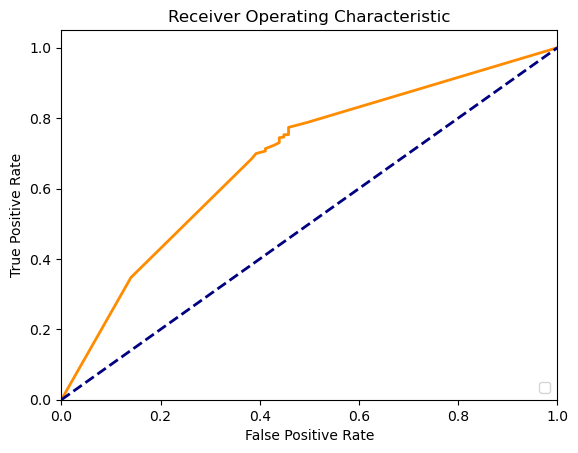

In [39]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color="darkorange", lw=lw)
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.6857375752586637

In [45]:
from sklearn.model_selection import StratifiedKFold
k=5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
smoothing_factor_option = [1,2,3,4,5,6]
fit_prior_option = [True, False]
auc_record = {}

In [48]:
for train_indices, test_indices in k_fold.split(X,Y):
    X_train_k, X_test_k = X[train_indices], X[test_indices]
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train_k, Y_train_k)
            prediction_prob = clf.predict_proba(X_test_k)
            pos_prob = prediction_prob[:,1]
            auc = roc_auc_score(Y_test_k, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

In [50]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f"   {smoothing}    {fit_prior}    {auc/k:5f}")

   1    True    0.952300
   1    False    0.952000
   2    True    0.950953
   2    False    0.952069
   3    True    0.953291
   3    False    0.953789
   4    True    0.953935
   4    False    0.953823
   5    True    0.955650
   5    False    0.954858
   6    True    0.955804
   6    False    0.955473


In [51]:
clf = MultinomialNB(alpha=5.0, fit_prior=True)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:,1]
print("AUC with the best model: ", roc_auc_score(Y_test, pos_prob))

AUC with the best model:  0.6842364372992429
